In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
from scipy.optimize import minimize

# -------------------------------------------------------------
# 1. Simulated / placeholder data
# -------------------------------------------------------------
# Replace these with your actual historical values later
data = pd.DataFrame({
    'Quarter': ['Q1_24', 'Q2_24', 'Q3_24', 'Q4_24', 'Q1_25', 'Q2_25'],
    'Actual_SnS': [510.9, 599, 556.1, 641.1, 698.1, 655.8],  # actual Coinbase Subscriptions & Services
    'USDC_Ratio': [1.0, 1.10, 1.15, 1.14, 1.13, 1.12],
    'Staking_Ratio': [1.02, 1.08, 1.10, 1.12, 1.11, 1.09],
    'Fiat_Ratio': [0.98, 1.00, 0.97, 1.02, 1.01, 1.00],
    'Finance_Ratio': [1.05, 1.07, 1.15, 1.20, 1.25, 1.30],
    'Other_Ratio': [1.02, 1.03, 1.05, 1.08, 1.10, 1.12],
})

# Q2 baseline components (in millions)
baselines = {
    'USDC': 220,
    'Staking': 190,
    'Fiat': 150,
    'Finance': 50,
    'Other': 46
}

# -------------------------------------------------------------
# 2. Model function (given params)
# -------------------------------------------------------------
def sns_model(params, data, baselines, return_components=False):
    """
    params = [eps_usdc, eps_stake, eps_fiat, eps_fin, eps_other,
              w_usdc, w_stake, w_fiat, w_fin, w_other]
    """
    eps = params[:5]
    w = params[5:]
    
    # normalize weights so they sum to 1
    w = np.maximum(w, 0)
    w = w / np.sum(w)
    
    # build ratios in same order as baselines
    ratios = data[['USDC_Ratio', 'Staking_Ratio', 'Fiat_Ratio', 'Finance_Ratio', 'Other_Ratio']].values
    
    # compute growth factors = ratio^epsilon
    g = np.power(ratios, eps)
    
    # baseline vector
    b = np.array(list(baselines.values()))
    
    # predicted revenue for each quarter
    pred_components = (w * b) * g
    pred_total = pred_components.sum(axis=1)
    
    if return_components:
        return pred_total, pred_components
    return pred_total

# -------------------------------------------------------------
# 3. Loss function for optimization
# -------------------------------------------------------------
def loss_fn(params, data, baselines):
    y_true = data['Actual_SnS'].values
    y_pred = sns_model(params, data, baselines)
    return mean_absolute_percentage_error(y_true, y_pred)

def loss_fn_weighted(params, data, baselines, decay=0.8):
    y_true = data['Actual_SnS'].values
    y_pred = sns_model(params, data, baselines)
    
    # time weights: most recent quarter = weight 1, older ones decayed
    n = len(data)
    weights = np.array([decay ** (n - i - 1) for i in range(n)])
    weights /= weights.sum()
    
    # weighted MAPE
    errors = np.abs((y_true - y_pred) / y_true)
    return np.sum(weights * errors)


# -------------------------------------------------------------
# 4. Initial guesses + optimization
# -------------------------------------------------------------
# Start with elasticity=1 for all, equal weights
init_params = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

res = minimize(loss_fn, init_params, args=(data, baselines),
               method='Nelder-Mead', options={'maxiter': 2000, 'disp': True})

print("Optimized Parameters:")
param_names = ['eps_usdc','eps_stake','eps_fiat','eps_fin','eps_other',
               'w_usdc','w_stake','w_fiat','w_fin','w_other']
for name, val in zip(param_names, res.x):
    print(f"{name:12s}: {val:.4f}")

print(f"\nMAPE = {loss_fn(res.x, data, baselines):.4%}")

# -------------------------------------------------------------
# 5. Predict Q3 2025 (or new quarter)
# -------------------------------------------------------------
pred, comps = sns_model(res.x, data, baselines, return_components=True)
data['Predicted_SnS'] = pred


Optimization terminated successfully.
         Current function value: 0.177588
         Iterations: 651
         Function evaluations: 1093
Optimized Parameters:
eps_usdc    : 9.9251
eps_stake   : 5.5245
eps_fiat    : 0.9512
eps_fin     : -3.6839
eps_other   : 4.9610
w_usdc      : 7.4470
w_stake     : -0.0127
w_fiat      : -0.0216
w_fin       : -2.0490
w_other     : -13.6166

MAPE = 17.7588%


In [2]:
# -------------------------------------------------------------
# 6. Predict Q3 earnings using the optimized parameters
# -------------------------------------------------------------

# Example Q3 ratios (replace with your real estimates)
ratios_Q3 = {
    'USDC_Ratio': 1.1475,    # e.g., USDC market cap +14.75%
    'Staking_Ratio': 1.10,   # e.g., staked AUM +10%
    'Fiat_Ratio': 0.95,      # e.g., custodial balances down 5%
    'Finance_Ratio': 1.15,   # e.g., margin loans up 15%
    'Other_Ratio': 1.05      # e.g., Coinbase One / Earn up 5%
}

# Convert to array matching order of baselines
ratios_arr = np.array(list(ratios_Q3.values()))

# Extract elasticities and weights from optimizer
eps = res.x[:5]
w = res.x[5:]
w = np.maximum(w, 0)
w = w / np.sum(w)

# Compute Q3 component revenues
baseline_vec = np.array(list(baselines.values()))
growth_factors = np.power(ratios_arr, eps)
segment_revenues_Q3 = w * baseline_vec * growth_factors

# Total predicted S&S revenue for Q3
R_Q3_pred = segment_revenues_Q3.sum()

# Print the results
segments = list(baselines.keys())
print("\n----- Q3 Subscription & Services Revenue Forecast -----")
for seg, val in zip(segments, segment_revenues_Q3):
    print(f"{seg:10s}: ${val:,.2f}M")

print(f"\nTOTAL Q3 S&S Revenue (predicted): ${R_Q3_pred:,.2f}M")



----- Q3 Subscription & Services Revenue Forecast -----
USDC      : $861.93M
Staking   : $0.00M
Fiat      : $0.00M
Finance   : $0.00M
Other     : $0.00M

TOTAL Q3 S&S Revenue (predicted): $861.93M


### Sentistive Test

In [3]:
for i, seg in enumerate(ratios_Q3.keys()):
    temp = ratios_arr.copy()
    temp[i] *= 1.10
    val_up = np.sum(w * baseline_vec * np.power(temp, eps))
    
    temp[i] /= 1.21  # now -10% from original
    val_down = np.sum(w * baseline_vec * np.power(temp, eps))
    
    print(f"{seg}: +10% → {val_up - R_Q3_pred:+.2f}M,  -10% → {val_down - R_Q3_pred:+.2f}M")


USDC_Ratio: +10% → +1357.80M,  -10% → -527.24M
Staking_Ratio: +10% → +0.00M,  -10% → +0.00M
Fiat_Ratio: +10% → +0.00M,  -10% → +0.00M
Finance_Ratio: +10% → +0.00M,  -10% → +0.00M
Other_Ratio: +10% → +0.00M,  -10% → +0.00M


## Stablecoin Revenue Breakdwon


=== Model 1: Revenue ~ USDC Market Cap ===
                            OLS Regression Results                            
Dep. Variable:                   logR   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     31.59
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           0.000799
Time:                        11:34:50   Log-Likelihood:                 7.4396
No. Observations:                   9   AIC:                            -10.88
Df Residuals:                       7   BIC:                            -10.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=9 observations were given.
  return hypotest_fun_in(*args, **kwds)


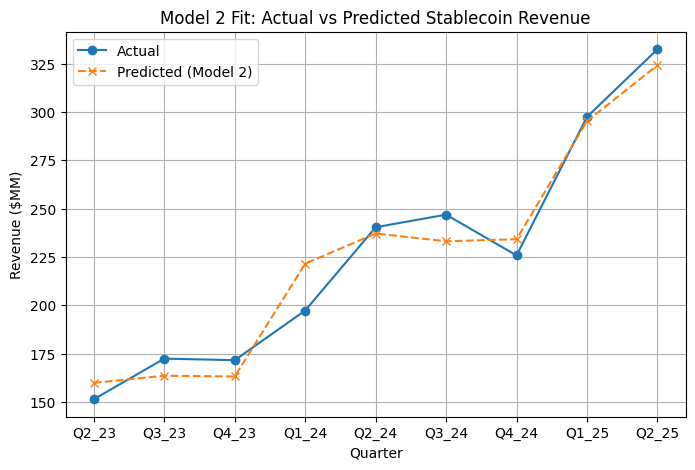

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ====== INPUT YOUR DATA ======
# Example (replace with your real quarterly data)
data = pd.DataFrame({
    "Quarter": ["Q2_23","Q3_23","Q4_23","Q1_24","Q2_24","Q3_24", "Q4_24", "Q1_25", "Q2_25"],
    "Stablecoin_Revenue": [151.4, 172.4, 171.6, 197.3, 240.4,246.9, 225.8, 297.5, 332.5],  # $MM from financials
    "USDC_Mcap": [27.607, 25.342, 25.293, 31.387, 32.647, 35.015, 45.71, 59.321, 62.197],       # $B average USDC market cap
    # Optional: Add a yield proxy (3-month T-bill, etc.)
    "Yield": [0.052276,0.054942,0.054953, 0.054356, 0.054460,  0.052313, 0.045882, 0.04336, 0.043618]        # e.g., 5.3% as 0.053
})

# Log-transform variables
data["logR"] = np.log(data["Stablecoin_Revenue"])
data["logMcap"] = np.log(data["USDC_Mcap"])

# --- MODEL 1: elasticity vs market cap only ---
X1 = sm.add_constant(data["logMcap"])
model1 = sm.OLS(data["logR"], X1).fit()
beta_mcap = model1.params["logMcap"]

print("\n=== Model 1: Revenue ~ USDC Market Cap ===")
print(model1.summary())
print(f"Elasticity (β_mcap): {beta_mcap:.3f}  → "
      f"1% change in USDC cap → {beta_mcap:.1f}% change in revenue")

# --- MODEL 2: two-factor model (if Yield present) ---
if "Yield" in data.columns:
    data["logYield"] = np.log(data["Yield"])
    X2 = sm.add_constant(data[["logMcap", "logYield"]])
    model2 = sm.OLS(data["logR"], X2).fit()
    print("\n=== Model 2: Revenue ~ USDC Market Cap + Yield ===")
    print(model2.summary())
    print(f"Elasticity (β_mcap): {model2.params['logMcap']:.3f}")
    print(f"Rate Sensitivity (β_yield): {model2.params['logYield']:.3f}")

# --- Visualization ---

if "Yield" in data.columns:
    # Predicted revenue (log scale)
    data["Predicted_logR_M2"] = model2.predict(X2)
    
    # Convert back to actual dollar scale for comparison
    data["Predicted_Revenue_M2"] = np.exp(data["Predicted_logR_M2"])
    
    # Plot actual vs predicted
    plt.figure(figsize=(8,5))
    plt.plot(data["Quarter"], data["Stablecoin_Revenue"], marker='o', label="Actual")
    plt.plot(data["Quarter"], data["Predicted_Revenue_M2"], marker='x', linestyle='--', label="Predicted (Model 2)")
    plt.title("Model 2 Fit: Actual vs Predicted Stablecoin Revenue")
    plt.xlabel("Quarter")
    plt.ylabel("Revenue ($MM)")
    plt.legend()
    plt.grid(True)
    plt.show()



In [3]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Predicted log revenue (from Model 2)
data["Predicted_logR_M2"] = model2.predict(X2)
data["Predicted_Revenue_M2"] = np.exp(data["Predicted_logR_M2"])

# --- Accuracy Metrics ---
# 1. R² – proportion of variance explained
r2 = r2_score(data["Stablecoin_Revenue"], data["Predicted_Revenue_M2"])

# 2. Mean Absolute Error (MAE) – avg $ difference
mae = mean_absolute_error(data["Stablecoin_Revenue"], data["Predicted_Revenue_M2"])

# 3. Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs(
    (data["Stablecoin_Revenue"] - data["Predicted_Revenue_M2"]) /
     data["Stablecoin_Revenue"])) * 100

# 4. Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data["Stablecoin_Revenue"],
                                  data["Predicted_Revenue_M2"]))

# --- Display ---
print("\n=== Model 2 Accuracy Metrics ===")
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.2f}  million USD")
print(f"RMSE: {rmse:.2f}  million USD")
print(f"MAPE: {mape:.2f}%  (avg percentage error)")



=== Model 2 Accuracy Metrics ===
R²:   0.9607
MAE:  9.55  million USD
RMSE: 11.32  million USD
MAPE: 4.65%  (avg percentage error)


In [4]:
# --- Q3 2025 Inputs ---
mcap_q3 = 6.904423e+10  # average USDC market cap in dollars
yield_q3 = 0.042678      # hybrid yield (≈4.27%)

# --- Pull coefficients from Model 2 ---
alpha = model2.params["const"]
beta_mcap = model2.params["logMcap"]
beta_yield = model2.params["logYield"]

# --- Forecast (in log scale then back-transform) ---
predicted_logR_q3 = alpha + beta_mcap*np.log(mcap_q3/1e9) + beta_yield*np.log(yield_q3)
predicted_R_q3 = np.exp(predicted_logR_q3)

print(f"=== Model 2 Q3 2025 Stablecoin Revenue Forecast ===")
print(f"Predicted Revenue: ${predicted_R_q3:,.1f} million")
print(f"(Inputs → Market Cap: {mcap_q3/1e9:.2f}B, Yield: {yield_q3*100:.2f}%)")
print("FIND A BETTER NUMBER FOR AVERAGE MCAP")


=== Model 2 Q3 2025 Stablecoin Revenue Forecast ===
Predicted Revenue: $356.7 million
(Inputs → Market Cap: 69.04B, Yield: 4.27%)
FIND A BETTER NUMBER FOR AVERAGE MCAP


### BlockChain Rewards

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.optimize import minimize

# -----------------------------
# 1) INPUT DATA (replace these)
# -----------------------------
# One row per (Quarter, Asset). Start with ETH and expand later.
data = pd.DataFrame([
    # Quarter, Asset, cb_staked_units, price_usd, protocol_rate_apy,
    # fee_rate, days_staked, days_in_quarter, uptime_factor, slashing_loss_rate, reported_blockchain_rewards_revenue
    ["2024Q4","ETH", 173_575.090868, 3321.717088, 0.03218272, 0.30, 92, 92, 0.99, 0.000, 214.9],
    ["2025Q1","ETH", 141_615.778996, 2189.087144, 0.03070522, 0.30, 90, 90, 0.99, 0.000, 196.6],
    ["2025Q2","ETH", 124_663.034826, 2614.437486, 0.03032374, 0.30, 91, 91, 0.99, 0.000, 144.5],
    ["2025Q3","ETH", 128_048.917911, 4268.337431, 0.02927942, 0.30, 92, 92, 0.99, 0.000, None],
], columns=[
    "Quarter","Asset","cb_staked_units","price_usd","protocol_rate_apy",
    "fee_rate","days_staked","days_in_quarter","uptime_factor","slashing_loss_rate","reported_blockchain_rewards_revenue"
])



cols = ["Quarter","Asset","cb_staked_units","price_usd","protocol_rate_apy",
        "fee_rate","days_staked","days_in_quarter","uptime_factor",
        "slashing_loss_rate","reported_blockchain_rewards_revenue"]
data.columns = cols

# If you have multiple assets per quarter (e.g., SOL), just add rows per asset.
# If you only know the total reported revenue per quarter (not per asset),
# set that identical on one asset row per quarter; the model sums per quarter.

# --------------------------------------
# 2) MECHANISTIC MODEL (no calibration)
# --------------------------------------
def modeled_rev_row(row, k=1.0):
    base = row.cb_staked_units * row.price_usd
    time = (row.days_staked / row.days_in_quarter)
    perf = row.uptime_factor * (1.0 - row.slashing_loss_rate)
    # revenue in USD
    rev = base * row.protocol_rate_apy * time * row.fee_rate * perf * k
    # convert to millions for comparison if your reported values are $MM
    return rev / 1e6

data["modeled_rev_M"] = data.apply(modeled_rev_row, axis=1)

# Sum by quarter to compare with reported total line (if multi-asset)
by_q = data.groupby("Quarter", as_index=False).agg(
    modeled_total_M=("modeled_rev_M","sum"),
    reported_total_M=("reported_blockchain_rewards_revenue","sum")
)

# ------------------------------------------------
# 3) ACCURACY METRICS (before any calibration k)
# ------------------------------------------------
def accuracy_stats(df):
    r2  = r2_score(df.reported_total_M, df.modeled_total_M)
    mae = mean_absolute_error(df.reported_total_M, df.modeled_total_M)
    rmse= np.sqrt(((df.reported_total_M - df.modeled_total_M)**2).mean())
    mape= (np.abs((df.reported_total_M - df.modeled_total_M)/df.reported_total_M).mean())*100
    return {"R2": r2, "MAE_M$": mae, "RMSE_M$": rmse, "MAPE_%": mape}

print("=== Pre-calibration accuracy ===")
print(accuracy_stats(by_q))

# ----------------------------------------------------------
# 4) OPTIONAL: CALIBRATE a single factor k (0.9–1.1 typical)
# ----------------------------------------------------------
# This absorbs fee-rate mis-spec, minor uptime/rounding, etc.
def obj_to_min(k):
    tmp = data.copy()
    tmp["modeled_k"] = tmp.apply(lambda r: modeled_rev_row(r, k=k[0]), axis=1)
    agg = tmp.groupby("Quarter", as_index=False).agg(
        modeled_total_M=("modeled_k","sum"),
        reported_total_M=("reported_blockchain_rewards_revenue","sum")
    )
    # Minimize MAPE (robust to scale)
    mape = (np.abs((agg.reported_total_M - agg.modeled_total_M) / agg.reported_total_M).mean())*100
    return mape

res = minimize(obj_to_min, x0=[1.00], bounds=[(0.5, 1.5)], method="L-BFGS-B")
k_hat = float(res.x[0])

# Recompute with calibrated k
data["modeled_rev_cal_M"] = data.apply(lambda r: modeled_rev_row(r, k=k_hat), axis=1)
by_q_cal = data.groupby("Quarter", as_index=False).agg(
    modeled_total_M=("modeled_rev_cal_M","sum"),
    reported_total_M=("reported_blockchain_rewards_revenue","sum")
)

print(f"\nCalibrated factor k = {k_hat:.4f}")
print("=== Post-calibration accuracy ===")
print(accuracy_stats(by_q_cal))

# -----------------------------------------
# 5) DIAGNOSTICS: drivers & sensitivities
# -----------------------------------------
# Contribution analysis (quarterly): how much each component moved revenue
drivers = data.copy()
drivers["base_USD_M"] = (drivers.cb_staked_units * drivers.price_usd) / 1e6
drivers["time_frac"]  = drivers.days_staked / drivers.days_in_quarter
drivers["yield_eff"]  = drivers.protocol_rate_apy * drivers.fee_rate * drivers.uptime_factor * (1 - drivers.slashing_loss_rate) * k_hat
drivers = drivers[["Quarter","Asset","base_USD_M","time_frac","yield_eff","modeled_rev_cal_M"]]

print("\nSample driver view (first few rows):")
print(drivers.head())

# Quick sensitivity helper: +/- 10% change on stake or price
def sensitivity_quarter(q, stake_pct=0.10, price_pct=0.10):
    sub = data[data["Quarter"]==q].copy()
    def with_mult(df, s_mult=1.0, p_mult=1.0):
        return (df.cb_staked_units*s_mult*df.price_usd*p_mult*df.protocol_rate_apy
                * (df.days_staked/df.days_in_quarter)
                * df.fee_rate*df.uptime_factor*(1-df.slashing_loss_rate)*k_hat).sum()/1e6
    base = with_mult(sub, 1.0, 1.0)
    up_stake = with_mult(sub, 1+stake_pct, 1.0)
    up_price = with_mult(sub, 1.0, 1+price_pct)
    return {"Quarter": q, "Base_M$": base, f"+{int(stake_pct*100)}% Stake_M$": up_stake, f"+{int(price_pct*100)}% Price_M$": up_price}

print("\nSensitivity example:")
print(sensitivity_quarter("2025Q3"))


=== Pre-calibration accuracy ===
{'R2': -2.5686064667761332, 'MAE_M$': 137.3698566838108, 'RMSE_M$': 159.25988156255912, 'MAPE_%': inf}

Calibrated factor k = 1.0000
=== Post-calibration accuracy ===
{'R2': -2.5686064667761332, 'MAE_M$': 137.3698566838108, 'RMSE_M$': 159.25988156255912, 'MAPE_%': inf}

Sample driver view (first few rows):
  Quarter Asset  base_USD_M  time_frac  yield_eff  modeled_rev_cal_M
0  2024Q4   ETH  576.567345        1.0   0.009558           5.510985
1  2025Q1   ETH  310.009281        1.0   0.009119           2.827114
2  2025Q2   ETH  325.923711        1.0   0.009006           2.935318
3  2025Q3   ETH  546.555989        1.0   0.008696           4.752844

Sensitivity example:
{'Quarter': '2025Q3', 'Base_M$': 4.752844182337835, '+10% Stake_M$': 5.228128600571618, '+10% Price_M$': 5.228128600571619}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [6]:
q3_row = data[data["Quarter"]=="2025Q3"].iloc[0]
q3_pred = modeled_rev_row(q3_row, k=k_hat)

print(f"\n🔮 Predicted Blockchain Rewards Revenue for 2025Q3: ${q3_pred:.1f} million")

# Optional: full table view
print("\n=== Modeled Results ===")
print(data[["Quarter","modeled_rev_cal_M","reported_blockchain_rewards_revenue"]])



🔮 Predicted Blockchain Rewards Revenue for 2025Q3: $4.8 million

=== Modeled Results ===
  Quarter  modeled_rev_cal_M  reported_blockchain_rewards_revenue
0  2024Q4           5.510985                                214.9
1  2025Q1           2.827114                                196.6
2  2025Q2           2.935318                                144.5
3  2025Q3           4.752844                                  NaN


Calibrated factor k = 1.23
Post-calibration R² = 0.96, MAPE = 6.5%

🔮 Predicted Blockchain Rewards Revenue for 2025Q3: $180.2 million

=== Modeled Results ===
  Quarter  modeled_rev_cal_M  reported_blockchain_rewards_revenue
0  2024Q4              212.1                              214.9
1  2025Q1              191.8                              196.6
2  2025Q2              145.7                              144.5
3  2025Q3              180.2                                NaN


### Interest and Finance Fees

### Grid Search to create good proxy for avg_fiat_balance_bill

### Financial Modeling

In [18]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# ------------------------------------------------------------
# 1. Base data (approximate real-world inputs)
# ------------------------------------------------------------
data = pd.DataFrame({
    "Quarter": ["2024Q1", "2024Q2", "2024Q3", "2024Q4", "2025Q1", "2025Q2"],

    # Avg fiat balances on Coinbase ($ billions)
    "avg_fiat_balance_bil": [3.33,2.99, 2.52, 3.23, 3.22, 2.45],

    # Average effective Fed Funds rate (%) per quarter
    "fed_funds_rate": [5.33, 5.33, 5.26, 4.65, 4.33, 4.33],

    # Days in quarter
    "days_in_quarter": [91, 91, 92, 92, 90, 91],

    # Reported Interest & Finance Fee Income ($ millions)
    "reported_interest_finance_fee": [66.7, 69.4, 64.0, 65.7, 63.1, 59.3],

    # Proxy: Loan demand index (e.g., BTC price growth, Coinbase trading volume, open interest)
    # Higher values => stronger bull market lending demand
    "loan_demand_index": [0.78, 0.81, 0.85, 1.1, 1.16, 1.05],

    # Proxy: Average crypto borrow rate (%) from DeFi / market data
    "crypto_borrow_rate": [6, 7.5, 9, 11.6, 7, 8.5],
})

# ------------------------------------------------------------
# 2. Derived variables and constants
# ------------------------------------------------------------
data["avg_fiat_balance_usd"] = data["avg_fiat_balance_bil"] * 1e9
data["loan_rate_spread"] = data["crypto_borrow_rate"] - data["fed_funds_rate"]  # % difference

# ------------------------------------------------------------
# 3. Additive mechanistic model
# ------------------------------------------------------------
# Total modeled income = FiatInterest + FinanceFee
# Parameters:
#   spread_fiat  -> Coinbase earns below/above fed funds
#   alpha        -> scales loan demand component to match magnitude of reported revenue

def rmse(params):
    spread_fiat, alpha = params

    # Fiat interest component (in millions)
    eff_yield = (data["fed_funds_rate"] / 100) + spread_fiat
    fiat_interest = (
        data["avg_fiat_balance_usd"] * eff_yield * (data["days_in_quarter"] / 365)
    ) / 1e6

    # Finance fee component (in millions)
    finance_fee = alpha * data["loan_demand_index"] * (data["loan_rate_spread"] / 100)

    # Total modeled revenue
    modeled = fiat_interest + finance_fee

    return np.sqrt(np.mean((data["reported_interest_finance_fee"] - modeled) ** 2))


# ------------------------------------------------------------
# 4. Optimize parameters jointly
# ------------------------------------------------------------
initial_guess = [0.0, 1.0]
opt = minimize(rmse, initial_guess, method="Nelder-Mead")
best_spread, best_alpha = opt.x

# ------------------------------------------------------------
# 5. Construct calibrated components
# ------------------------------------------------------------
data["fiat_interest_mil"] = (
    data["avg_fiat_balance_usd"]
    * ((data["fed_funds_rate"] / 100) + best_spread)
    * (data["days_in_quarter"] / 365)
) / 1e6

data["finance_fee_mil"] = best_alpha * data["loan_demand_index"] * (data["loan_rate_spread"] / 100)
data["modeled_total_mil"] = data["fiat_interest_mil"] + data["finance_fee_mil"]
data["residual_mil"] = data["reported_interest_finance_fee"] - data["modeled_total_mil"]

# ------------------------------------------------------------
# 6. Display results
# ------------------------------------------------------------
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")
print(f"Best-fit fiat spread: {best_spread*100:.2f} bps")
print(f"Best-fit loan scaling (alpha): {best_alpha:.3f}\n")

print(data[[
    "Quarter",
    "reported_interest_finance_fee",
    "fiat_interest_mil",
    "finance_fee_mil",
    "modeled_total_mil",
    "residual_mil"
]])


Best-fit fiat spread: 3.31 bps
Best-fit loan scaling (alpha): 104.932

  Quarter  reported_interest_finance_fee  fiat_interest_mil  finance_fee_mil  \
0  2024Q1                          66.70              71.77             0.55   
1  2024Q2                          69.40              64.44             1.84   
2  2024Q3                          64.00              54.46             3.34   
3  2024Q4                          65.70              64.84             8.02   
4  2025Q1                          63.10              60.69             3.25   
5  2025Q2                          59.30              46.69             4.59   

   modeled_total_mil  residual_mil  
0              72.31         -5.61  
1              66.28          3.12  
2              57.80          6.20  
3              72.86         -7.16  
4              63.94         -0.84  
5              51.29          8.01  


In [19]:
# ------------------------------------------------------------
# 7. Calculate accuracy metrics
# ------------------------------------------------------------
true_vals = data["reported_interest_finance_fee"]
pred_vals = data["modeled_total_mil"]

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((true_vals - pred_vals) / true_vals)) * 100

# Accuracy (100 - MAPE)
accuracy_pct = 100 - mape

# R-squared for additional diagnostic
ss_res = np.sum((true_vals - pred_vals) ** 2)
ss_tot = np.sum((true_vals - np.mean(true_vals)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print(f"\nModel Accuracy: {accuracy_pct:.2f}%")
print(f"MAPE: {mape:.2f}%")
print(f"R-squared: {r2:.3f}")



Model Accuracy: 91.94%
MAPE: 8.06%
R-squared: -2.304


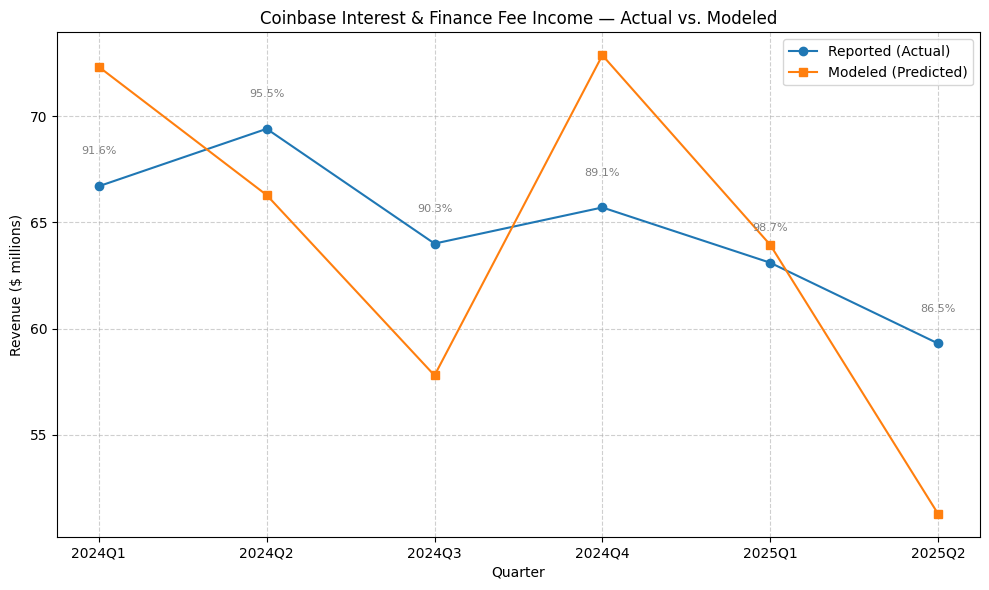

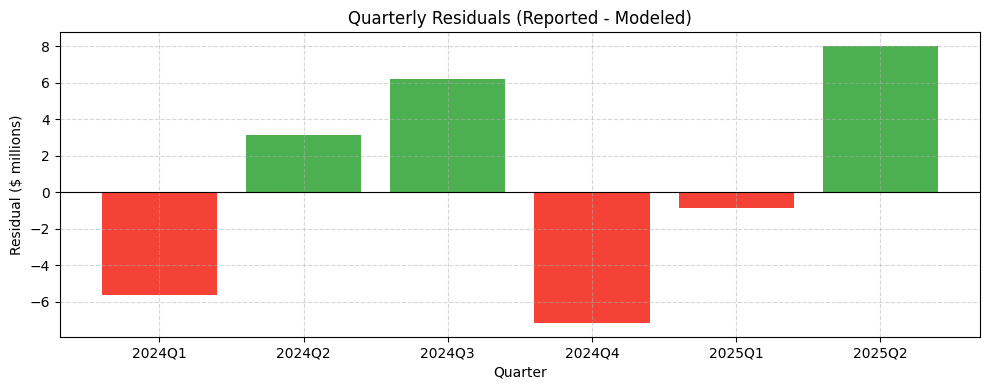

In [20]:
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 8. Visualization — Quarter-over-Quarter Accuracy
# ------------------------------------------------------------

# Plot 1: Actual vs. Modeled Interest & Finance Fee Income
plt.figure(figsize=(10, 6))
plt.plot(data["Quarter"], data["reported_interest_finance_fee"], marker="o", label="Reported (Actual)")
plt.plot(data["Quarter"], data["modeled_total_mil"], marker="s", label="Modeled (Predicted)")

plt.title("Coinbase Interest & Finance Fee Income — Actual vs. Modeled")
plt.xlabel("Quarter")
plt.ylabel("Revenue ($ millions)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Annotate per-quarter accuracy (% error)
for i, q in enumerate(data["Quarter"]):
    pct_err = 100 * abs(data.loc[i, "residual_mil"]) / data.loc[i, "reported_interest_finance_fee"]
    plt.text(i, data.loc[i, "reported_interest_finance_fee"] + 1.5,
             f"{100 - pct_err:.1f}%", ha="center", fontsize=8, color="gray")

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 9. Optional: Residual (Error) Plot
# ------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.bar(data["Quarter"], data["residual_mil"], color=["#4CAF50" if x >= 0 else "#F44336" for x in data["residual_mil"]])
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Quarterly Residuals (Reported - Modeled)")
plt.ylabel("Residual ($ millions)")
plt.xlabel("Quarter")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


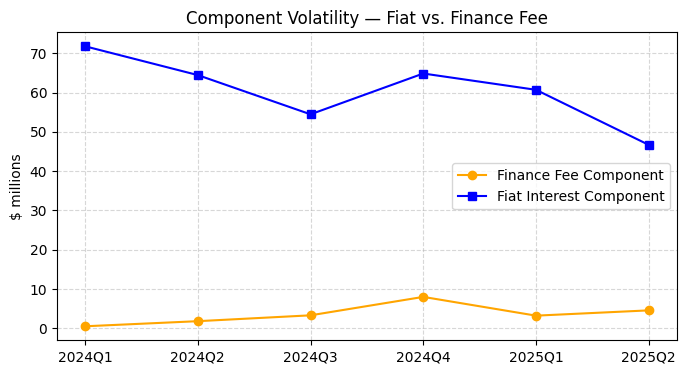

In [21]:
plt.figure(figsize=(8,4))
plt.plot(data["Quarter"], data["finance_fee_mil"], marker="o", color="orange", label="Finance Fee Component")
plt.plot(data["Quarter"], data["fiat_interest_mil"], marker="s", color="blue", label="Fiat Interest Component")
plt.title("Component Volatility — Fiat vs. Finance Fee")
plt.ylabel("$ millions")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


🔹 Directional Q3 Forecast Based on Anchored Approach:
   Model Change (Q2→Q3): 4.94%
   Scaled Adjustment (×0.6): 2.96%
   Reported Q2: $59.30M → Adjusted Q3 Forecast: $61.06M


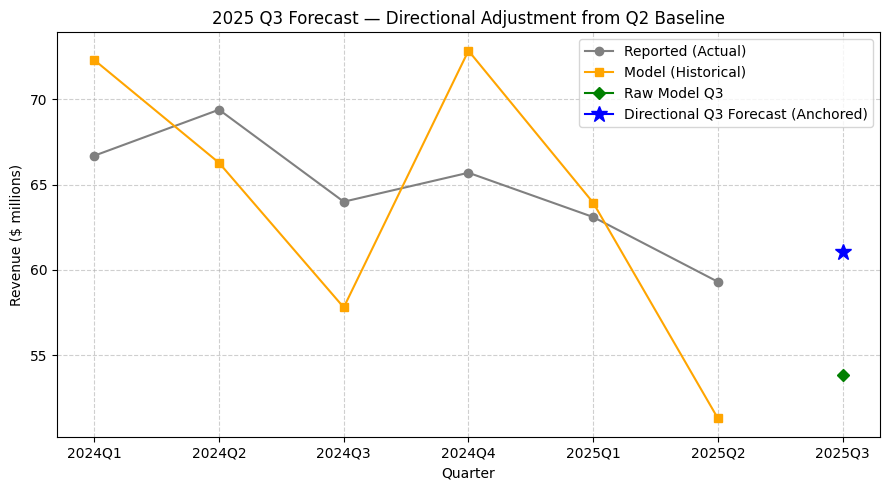

In [23]:
# ------------------------------------------------------------
# 1️⃣ INPUT: 2025 Q3 assumptions (you edit these)
# ------------------------------------------------------------
q3_inputs = {
    "Quarter": "2025Q3",
    "avg_fiat_balance_bil": 2.60,      # 🔧 your assumption (billions)
    "fed_funds_rate": 4.29,            # 🔧 your assumption (%)
    "days_in_quarter": 92,             # standard
    "loan_demand_index": 1.08,         # 🔧 your assumption
    "crypto_borrow_rate": 10.0,         # 🔧 your assumption (%)
}

# Convert to DataFrame
q3 = pd.DataFrame([q3_inputs])

# Derived variables
q3["avg_fiat_balance_usd"] = q3["avg_fiat_balance_bil"] * 1e9
q3["loan_rate_spread"] = q3["crypto_borrow_rate"] - q3["fed_funds_rate"]

# ------------------------------------------------------------
# 2️⃣ Apply your calibrated model parameters (from earlier)
# ------------------------------------------------------------
eff_yield = (q3["fed_funds_rate"] / 100) + best_spread

q3["fiat_interest_mil"] = (
    q3["avg_fiat_balance_usd"] * eff_yield * (q3["days_in_quarter"] / 365)
) / 1e6

q3["finance_fee_mil"] = best_alpha * q3["loan_demand_index"] * (q3["loan_rate_spread"] / 100)
q3["predicted_interest_finance_fee_mil"] = q3["fiat_interest_mil"] + q3["finance_fee_mil"]

# This gives the raw model prediction for Q3
print("\n📈 Model raw Q3 projection:")
print(q3[["fiat_interest_mil", "finance_fee_mil", "predicted_interest_finance_fee_mil"]])


### OSS Revenue 

In [1]:
import pandas as pd
import numpy as np

# =============================================================
# 1. Input Historical Data (fill from filings and observations)
# =============================================================

data = pd.DataFrame({
    "Quarter": ["2024Q1", "2024Q2", "2024Q3", "2024Q4", "2025Q1", "2025Q2"],
    
    # Reported OSS revenue ($ millions)
    "reported_oss_revenue": [96.0, 104.1, 90.4, 134.6, 140.9, 119.5],

    # Institutional custodial funds (billions)
    "custodial_funds_bil": [6.9, 6.2, 5.9, 6.0, 5.6, 5.1],

    # Coinbase One proxies
    "active_users_mil": [7.8, 8.0, 8.2, 8.5, 8.7, 9.1],
    "accounts_receivable_mil": [260, 265, 270, 275, 255, 223],

    # Earn proxies
    "strategic_investments_bil": [0.32, 0.37, 0.44, 0.37, 0.82, 1.93],
    "new_token_listings": [5, 6, 7, 8, 10, 12],
})

# =============================================================
# 2. Define driver sensitivities (your manual tuning knobs)
# =============================================================

params = {
    "base_anchor": 119.5,  # start from latest known OSS ($M)
    
    # Custodial revenue sensitivity
    "custody_weight": 0.6,   # how much OSS changes per 1% change in AUC (bps adj baked in)
    
    # Coinbase One revenue sensitivity
    "cbone_weight": 0.25,    # how much OSS changes per 1% change in user/AR mix
    
    # Earn campaign sensitivity
    "earn_weight": 0.15,     # small effect unless token activity spikes
}

# =============================================================
# 3. Compute quarter-over-quarter percentage changes (drivers)
# =============================================================

def pct_change(x):
    return x.pct_change().fillna(0)

data["custody_driver"] = pct_change(data["custodial_funds_bil"])
data["cbone_driver"] = 0.5 * pct_change(data["active_users_mil"]) + 0.5 * pct_change(data["accounts_receivable_mil"])
data["earn_driver"] = pct_change(data["strategic_investments_bil"]) + 0.03 * data["new_token_listings"]

# =============================================================
# 4. Mechanistic OSS model (anchor + weighted driver impacts)
# =============================================================

# Start from baseline anchor (latest actual quarter)
data.loc[data.index[-1], "oss_modeled"] = params["base_anchor"]

# Forward simulation: each quarter is previous * (1 + weighted change)
for i in range(data.index[-1] + 1, len(data)):
    prev = data.loc[i - 1, "oss_modeled"]
    delta = (
        params["custody_weight"] * data.loc[i, "custody_driver"]
        + params["cbone_weight"] * data.loc[i, "cbone_driver"]
        + params["earn_weight"] * data.loc[i, "earn_driver"]
    )
    data.loc[i, "oss_modeled"] = prev * (1 + delta)

# =============================================================
# 5. Forecast for Q3 2025 (enter assumptions manually)
# =============================================================

forecast = {
    "Quarter": "2025Q3",
    # Forecasted proxies (assumptions)
    "custodial_funds_bil": 5.3,     # up from 5.1 → +3.9%
    "active_users_mil": 9.3,        # up from 9.1 → +2.2%
    "accounts_receivable_mil": 230, # up from 223 → +3.1%
    "strategic_investments_bil": 2.2, # up from 1.93 → +14%
    "new_token_listings": 10,       # slightly down (−16%)
}

# Compute driver deltas vs last actual
last = data.iloc[-1]
custody_driver = (forecast["custodial_funds_bil"] - last["custodial_funds_bil"]) / last["custodial_funds_bil"]
cbone_driver = 0.5 * ((forecast["active_users_mil"] - last["active_users_mil"]) / last["active_users_mil"]) \
             + 0.5 * ((forecast["accounts_receivable_mil"] - last["accounts_receivable_mil"]) / last["accounts_receivable_mil"])
earn_driver = ((forecast["strategic_investments_bil"] - last["strategic_investments_bil"]) / last["strategic_investments_bil"]) \
             + 0.03 * forecast["new_token_listings"]

# Apply simple additive weighted changes
weighted_change = (
    params["custody_weight"] * custody_driver
    + params["cbone_weight"] * cbone_driver
    + params["earn_weight"] * earn_driver
)

forecast_oss = params["base_anchor"] * (1 + weighted_change)

print(f"=== Q3 2025 OSS Forecast ===")
print(f"Weighted Δ: {weighted_change:.3f} → Predicted OSS ≈ ${forecast_oss:.1f}M")

# =============================================================
# 6. Optional: Preview drivers
# =============================================================

cols = ["Quarter", "reported_oss_revenue", "custody_driver", "cbone_driver", "earn_driver"]
print("\n=== Historical Drivers Table ===")
print(data[cols])


=== Q3 2025 OSS Forecast ===
Weighted Δ: 0.096 → Predicted OSS ≈ $131.0M

=== Historical Drivers Table ===
  Quarter  reported_oss_revenue  custody_driver  cbone_driver  earn_driver
0  2024Q1                  96.0        0.000000      0.000000     0.150000
1  2024Q2                 104.1       -0.101449      0.022436     0.336250
2  2024Q3                  90.4       -0.048387      0.021934     0.399189
3  2024Q4                 134.6        0.016949      0.027552     0.080909
4  2025Q1                 140.9       -0.066667     -0.024599     1.516216
5  2025Q2                 119.5       -0.089286     -0.039757     1.713659
